In [1]:
# prepare dependencies

import numpy as np
from utils import load_surf, load_config, butterworth_highpass, zscore, load_mp3, get_envelope, lanczosinterp2D, get_logger
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import nibabel as nib
import os
import time

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']

logging = get_logger()

subject = 'sub-007'
session = 'ses-01'

tr = 1.5

In [ ]:
# load Auditory Localizer data
from nilearn import surface
hemi = 'L'
task = 'AuditoryLocalizer'
surf_file = os.path.join(DATADIR, subject, session, 'func', f'{subject}_{session}_task-{task}_hemi-{hemi}_space-fsaverage6_bold.func.gii')
if not os.path.exists(surf_file):
    logging.error(f"Surface file {surf_file} does not exist.")

surf_data = surface.load_surf_data(surf_file)
sdata_al = np.array(surf_data, dtype=np.float64)

sdata_al = zscore(butterworth_highpass(sdata_al, tr, 0.01), axis=1)
print(sdata_al.shape)

In [ ]:
# reshape the 200 trs into 5 blocks of 40 trs
sdata_al_reshaped = sdata_al.reshape(sdata_al.shape[0], 5, 40)

In [ ]:
# load auditory localizer envelope
from scipy.io import wavfile
wav_file = os.path.join(STIMDIR, 'auditory_localizer.wav')
sr, audio = wavfile.read(wav_file)

audio_envelope = get_envelope(audio)[:, 0]

audio_envelope = np.pad(audio_envelope, (0, 60 * sr - len(audio_envelope)), 'constant', constant_values=0)

# downsample the envelope to match the number of TRs
audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * tr) * int(sr * tr)].reshape(-1, int(sr * tr)), axis=1)

print(audio_envelope_avg.shape)

env = zscore(np.tile(audio_envelope_avg, 5))


(40,)


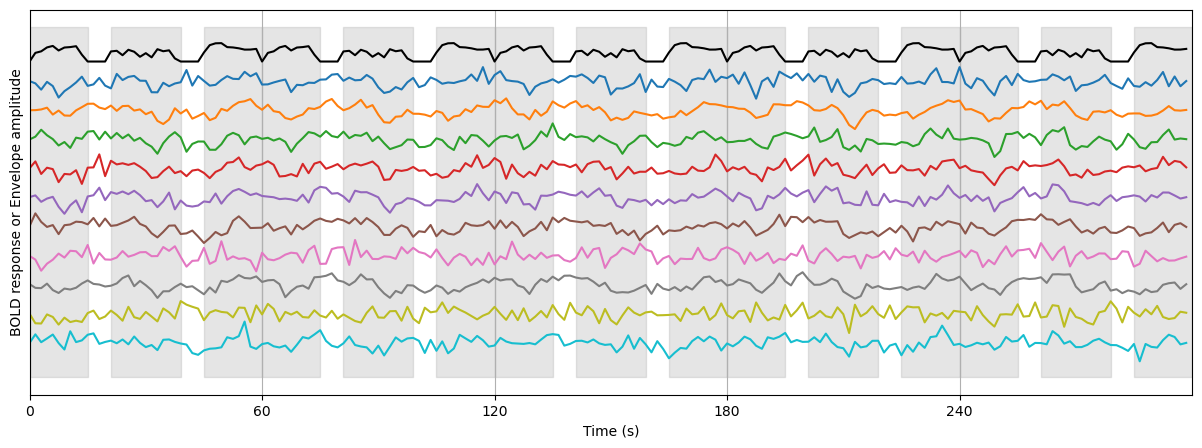

In [ ]:
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage('fsaverage6')

surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/lh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

aud_voxels = np.where(surf_labels == surf_names.index('17Networks_LH_SomMotB_Aud_2'))[0]

selvoxels = np.random.choice(aud_voxels, 10, replace=False)

# selvoxels = [1663, 16953, 11411, 3732, 25149]

figure = plt.figure(figsize=(15, 5))
ax = figure.add_subplot(111)

ax.plot(np.arange(env.shape[0]) * tr, env + 5, 'k', label="Envelope")

for i, v in enumerate(selvoxels):
    ax.plot(np.arange(sdata_al.shape[1]) * tr, zscore(sdata_al[v]) - i * 5, label=f"vertex {v}")

yl = ax.get_ylim()

for irep in range(5):
    ax.fill_between([irep * 60, irep * 60 + 15], yl[0], yl[1], color='gray', alpha=0.2)
    ax.fill_between([irep * 60 + 21, irep * 60 + 39], yl[0], yl[1], color='gray', alpha=0.2)
    ax.fill_between([irep * 60 + 45, irep * 60 + 60], yl[0], yl[1], color='gray', alpha=0.2)

ax.set_xlim(0, 300)
ax.set_xticks(range(0, 300, 60))
ax.set_yticks([])

ax.set_xlabel("Time (s)")
ax.set_ylabel("BOLD response or Envelope amplitude")
ax.grid()

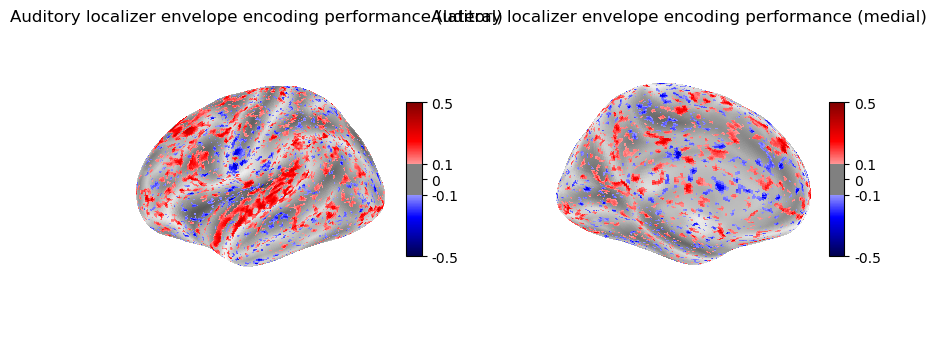

In [ ]:
# fit encoding model with audio envelope
from utils import make_delayed
from ridge import ridge_cv
from nilearn import plotting

n_reps = 10
alphas = np.logspace(-3, 3, 7)
nfolds = 10

n_delays = 5 # 7.5 seconds
xdata = make_delayed(env[:, np.newaxis], np.arange(1, n_delays + 1))

encperf_all = np.zeros((n_reps, sdata_al.shape[0]))
for i_rep in range(n_reps):
    wt, corr, best_alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, sdata_al.T, alphas, nfolds)
    encperf_all[i_rep] = voxcorrs

encperf_al = np.mean(encperf_all, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fl = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf_al, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, threshold=0.1, axes=axes[0], title='Auditory localizer envelope encoding performance (lateral)')
fm = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf_al, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, threshold=0.1, axes=axes[1], title='Auditory localizer envelope encoding performance (medial)')

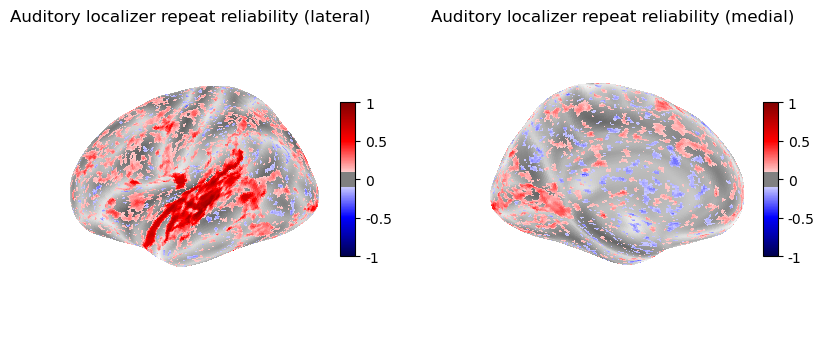

In [ ]:
# repeat reliability
from utils import pearsonr
rr = np.zeros(sdata_al_reshaped.shape[0])
for i in range(sdata_al_reshaped.shape[1]):
    avg_others = np.mean(sdata_al_reshaped[:, np.arange(sdata_al_reshaped.shape[1]) != i, :], axis=1)
    rr += pearsonr(sdata_al_reshaped[:, i].T, avg_others.T) / sdata_al_reshaped.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fl = plotting.plot_surf_stat_map(fsaverage.infl_left, rr, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=1, vmin=-1, threshold=0.1, axes=axes[0], title='Auditory localizer repeat reliability (lateral)')
fm = plotting.plot_surf_stat_map(fsaverage.infl_left, rr, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=1, vmin=-1, threshold=0.1, axes=axes[1], title='Auditory localizer repeat reliability (medial)')

In [ ]:
# story audio envelope encoding model
task = 'treasureisland'
hemi = 'L'
surf_file = os.path.join(DATADIR, subject, session, 'func', f'{subject}_{session}_task-{task}_hemi-{hemi}_space-fsaverage6_bold.func.gii')
if not os.path.exists(surf_file):
    logging.error(f"Surface file {surf_file} does not exist.")

surf_data = surface.load_surf_data(surf_file)
sdata = np.array(surf_data, dtype=np.float64)

sdata = zscore(butterworth_highpass(sdata, tr, 0.01), axis=1)

# load wav
wav_file = os.path.join(STIMDIR, 'treasureisland.wav')
sr, audio = wavfile.read(wav_file)

audio_envelope = get_envelope(audio)[:, 0]

audio_envelope_avg = np.mean(audio_envelope[:len(audio_envelope) // int(sr * tr) * int(sr * tr)].reshape(-1, int(sr * tr)), axis=1)

zEnv = zscore(audio_envelope_avg)

sdata = sdata[:, 2:zEnv.shape[0]+2]

/var/folders/r2/rgb930tj5ss_cmb9qkb2mfym0000gn/T/ipykernel_38041/1064898386.py:15: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, audio = wavfile.read(wav_file)


Text(0, 0.5, 'Correlation')

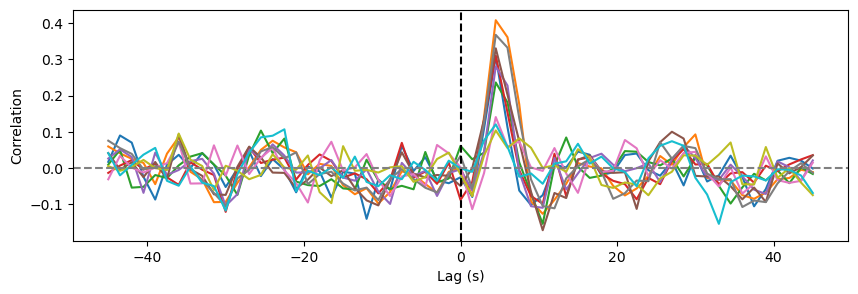

In [ ]:
from matplotlib.pyplot import figure
f1 = figure(figsize=(10, 3))
f1.clf()
ax = f1.add_subplot(1,1,1)
def lagcorr(x, y, maxlag=10):
    lags = np.arange(-maxlag, maxlag + 1)
    corrs = np.zeros(lags.shape)
    for i, lag in enumerate(lags):
        if lag < 0:
            corrs[i] = np.corrcoef(x[:lag], y[-lag:])[0, 1]
        elif lag == 0:
            corrs[i] = np.corrcoef(x, y)[0, 1]
        else:
            corrs[i] = np.corrcoef(x[lag:], y[:-lag])[0, 1]
    
    return lags, corrs

for i, voxel in enumerate(selvoxels):
    lags, ccorrs = lagcorr(sdata[voxel, :], zEnv, maxlag=30)
    ax.plot(lags * tr, ccorrs)

ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')
ax.set_xlabel("Lag (s)")
ax.set_ylabel("Correlation")

In [ ]:
# audio encoding model

n_reps = 10
alphas = np.logspace(-3, 3, 7)
nfolds = 5

n_delays = 5 # 7.5 seconds
xdata = make_delayed(zEnv[:, np.newaxis], np.arange(1, n_delays + 1))

encperf_all = np.zeros((n_reps, sdata.shape[0]))
for i_rep in range(n_reps):
    wt, corr, best_alphas, bscorrs, valinds, voxcorrs = ridge_cv(xdata, sdata.T, alphas, nfolds)
    encperf_all[i_rep, :] = voxcorrs

encperf = np.mean(encperf_all, axis=0)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': '3d'})

fl = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf, hemi='left', view='lateral', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, threshold=0.1, axes=axes[0], title='Treasure Island envelope encoding performance (lateral)')
fm = plotting.plot_surf_stat_map(fsaverage.infl_left, encperf, hemi='left', view='medial', colorbar=True, bg_map=fsaverage.sulc_left, cmap='seismic', vmax=0.5, vmin=-0.5, threshold=0.1, axes=axes[1], title='Treasure Island envelope encoding performance (medial)')